<a href="https://colab.research.google.com/github/alik604/cyber-security/blob/master/anomalyDetection/SPX_500_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Anomaly Detection Notebook

list of sources 
* https://github.com/edyoda/data-science-complete-tutorial/blob/master/13.%20Anomaly%20Detection.ipynb



In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

!pip install yfinance
import yfinance as yf # https://github.com/ranaroussi/yfinance

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

%config IPCompleter.greedy=True

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=56f99ae49ec5c220fcbbb5b3e045dbeda0021e93831bbe0246e4ec40eb2cac24
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
SPY = yf.Ticker("spy")
SPY = SPY.history(period='20y') # max
SPY_open = pd.DataFrame({'close':SPY["Close"]})
# SPY_open.head(10)
SPY_open.tail(10)

,close
Date,
2020-06-15,305.70
2020-06-16,311.59
2020-06-17,310.29
2020-06-18,310.41
2020-06-19,308.64
2020-06-22,310.62
2020-06-23,312.05
2020-06-24,304.09
2020-06-25,307.35


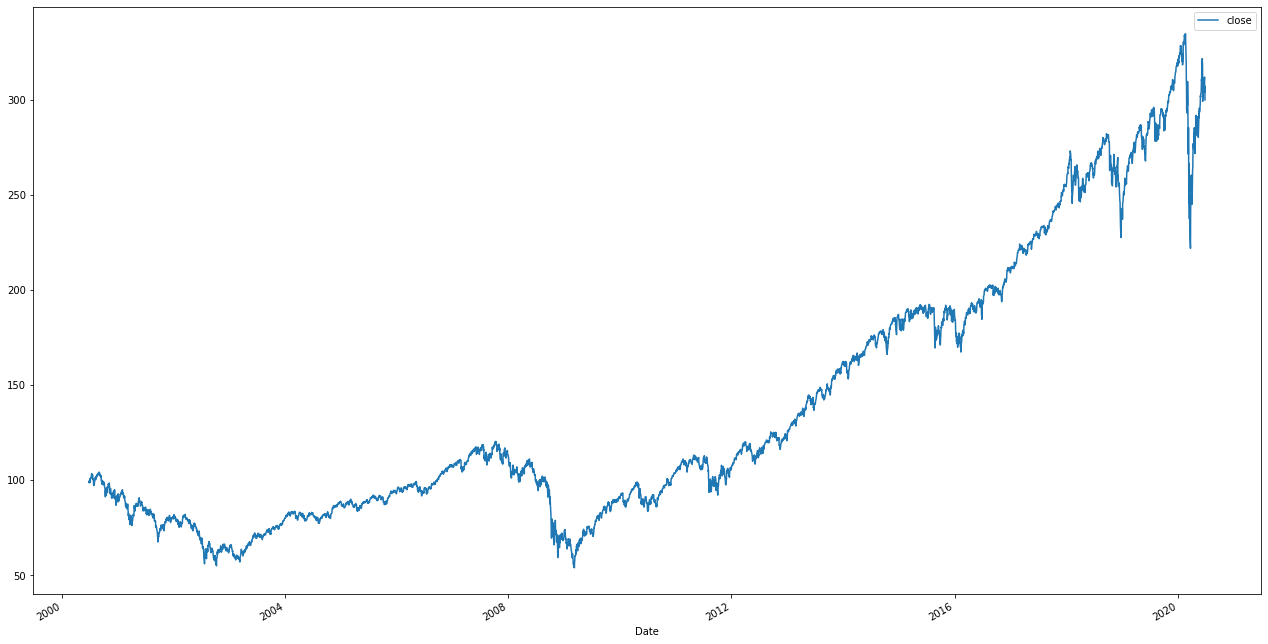

In [3]:
spy = SPY_open
spy.plot(figsize=(22,12), use_index=True)

In [4]:
x= spy.close.values # ndarray 
x_nested = x.reshape(-1,1)

## K-Means

<Figure size 864x432 with 0 Axes>

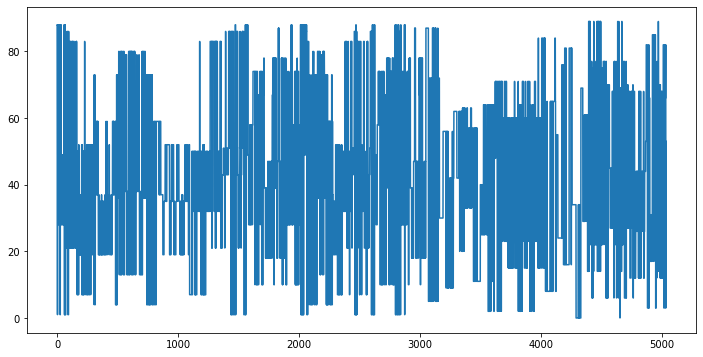

In [5]:
km = KMeans(90).fit(x_nested)
# plt.figure(figsize=(12,6))
# plt.plot(km.cluster_centers_)
# print(np.sort(km.cluster_centers_.reshape(1,-1)[0]))

plt.figure(figsize=(12,6))
plt.plot(range(spy.shape[0]),km.predict(x_nested))

## IsolationForest

In [6]:
clf = IsolationForest(max_samples='auto', contamination=.05, n_estimators=1000,
                      random_state=19117,  max_features=x_nested.shape[1],behaviour='new') #  added : behaviour='new'

#.025 , .22 ,.15 

In [7]:
pred = clf.fit(x_nested)
p = pred.predict(x_nested)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


### Well this is useless 


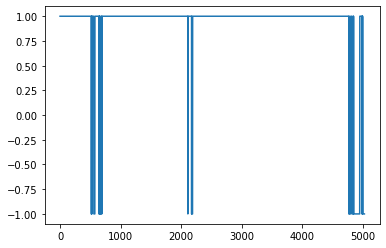

In [8]:
#plt.figure(figsize=(12,6))
plt.plot(p)

### Let's figure out how to plot it...


In [9]:
arry = p.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
#itemindex

<Figure size 1800x864 with 0 Axes>

Text(0.5, 1.0, 'IsolationForest - S&P 500')

[]

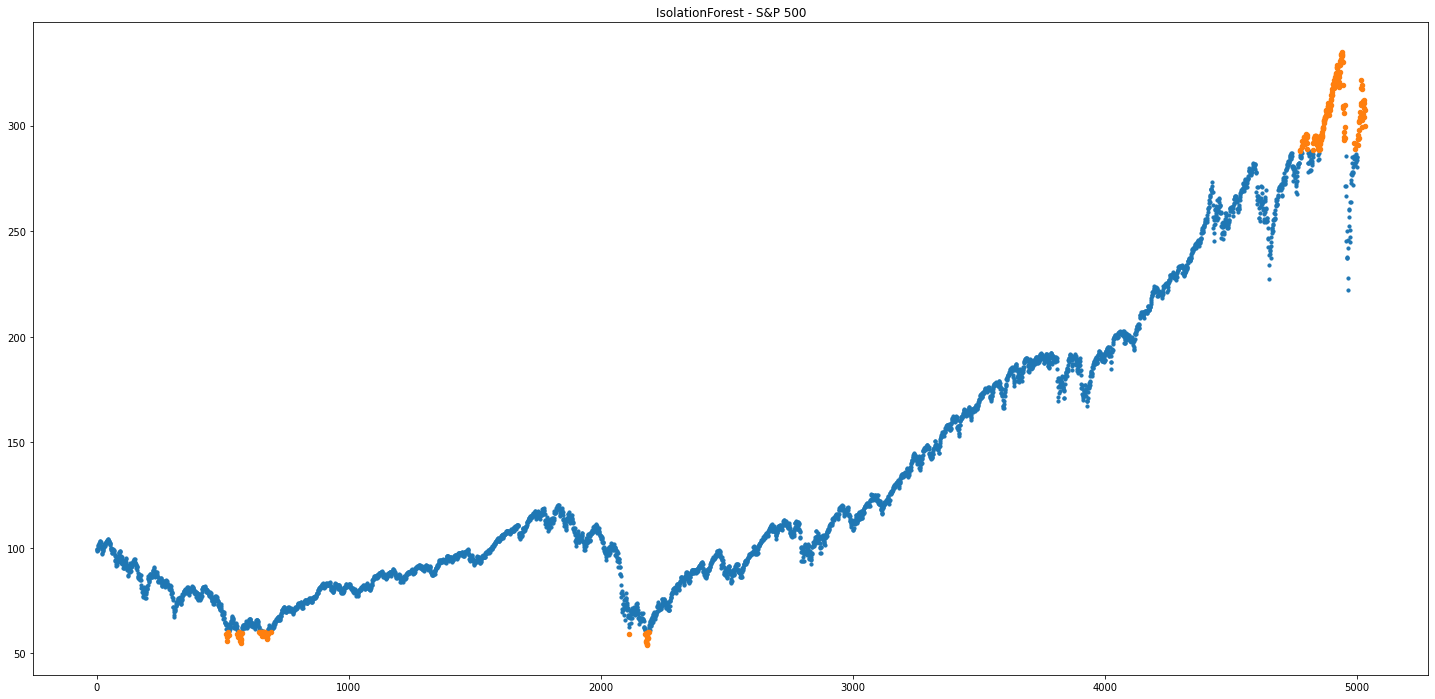

In [10]:
plt.figure(figsize=(25,12))
plt.title("IsolationForest - S&P 500")
x_axis = range(len(x))
out = plt.scatter(x_axis,y=x,s=10)
plt.scatter(itemindex,x[itemindex],s=20)
plt.plot()

In [11]:
anomalies = pd.DataFrame({
    'x' :list(itemindex)[0], 'y': x[itemindex]

})
anomalies
#anomalies.plot(x='x',y='y',figsize=(24,12), kind='scatter')

,x,y
0,515,59.37
1,516,57.61
2,517,56.03
3,518,59.37
4,519,58.87
...,...,...
247,5027,310.62
248,5028,312.05
249,5029,304.09
250,5030,307.35


## Lets try GaussianMixture 

In [12]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5)
gmm.fit(x_nested)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
pred = gmm.predict(x_nested)
pred_prob = gmm.predict_proba(x_nested)
scores= gmm.score_samples(x_nested)
scoresMean = scores.mean()

In [14]:
#print(pred[:1000])

In [15]:
itemindex = np.where(pred>0)

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'GaussianMixture - S&P 500')

[]

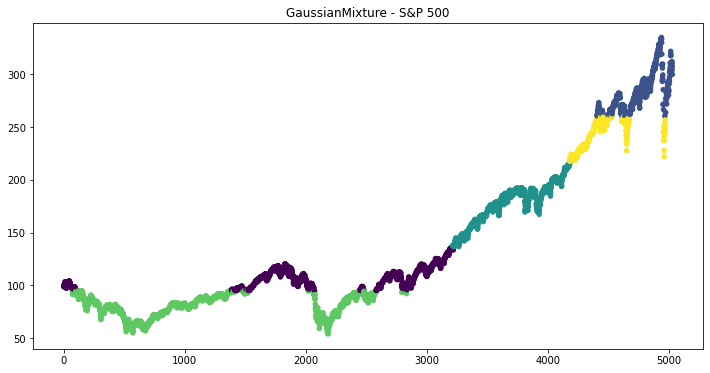

In [16]:
plt.figure(figsize=(12,6))
plt.title("GaussianMixture - S&P 500")
x_axis = range(len(x))
out = plt.scatter(x_axis,y=x,s=20,c=pred) # added c=pred
#plt.scatter(itemindex,x[itemindex],s=20,color='r') #

plt.plot()

This sames to be the worng algo for the job, let's move on..

## OK lets try what EllipticEnvelope is  

In [17]:
from sklearn.covariance import EllipticEnvelope
ev = EllipticEnvelope(contamination=.15)
ev.fit(x_nested)

EllipticEnvelope(assume_centered=False, contamination=0.15, random_state=None,
                 store_precision=True, support_fraction=None)

<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'EllipticEnvelope - S&P 500')

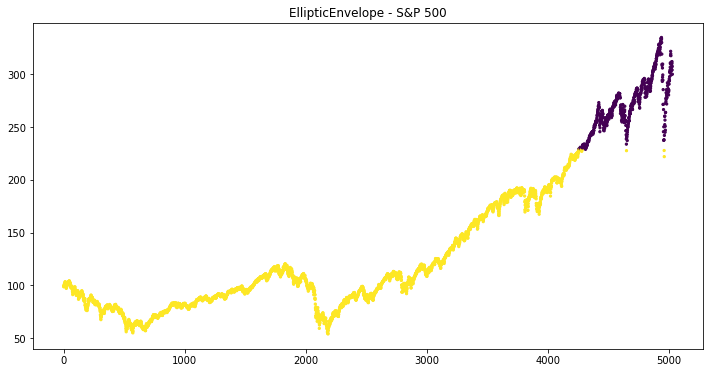

In [18]:
cluster = ev.predict(x_nested)

plt.figure(figsize=(12,6))
plt.title("EllipticEnvelope - S&P 500")
plt.scatter(range(len(x_nested)), x_nested, s=5, c=cluster)

well thats also useless... half the time, its just the top n%

## Let's try OneClassSVM 

In [19]:
from sklearn.svm import OneClassSVM
svm = OneClassSVM(degree=5)
svm.fit(x_nested)
pred = svm.predict(x_nested)

OneClassSVM(cache_size=200, coef0=0.0, degree=5, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [20]:
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

len of arry:       5032
len of itemindex:  2516


<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'OneClassSVM - S&P 500')

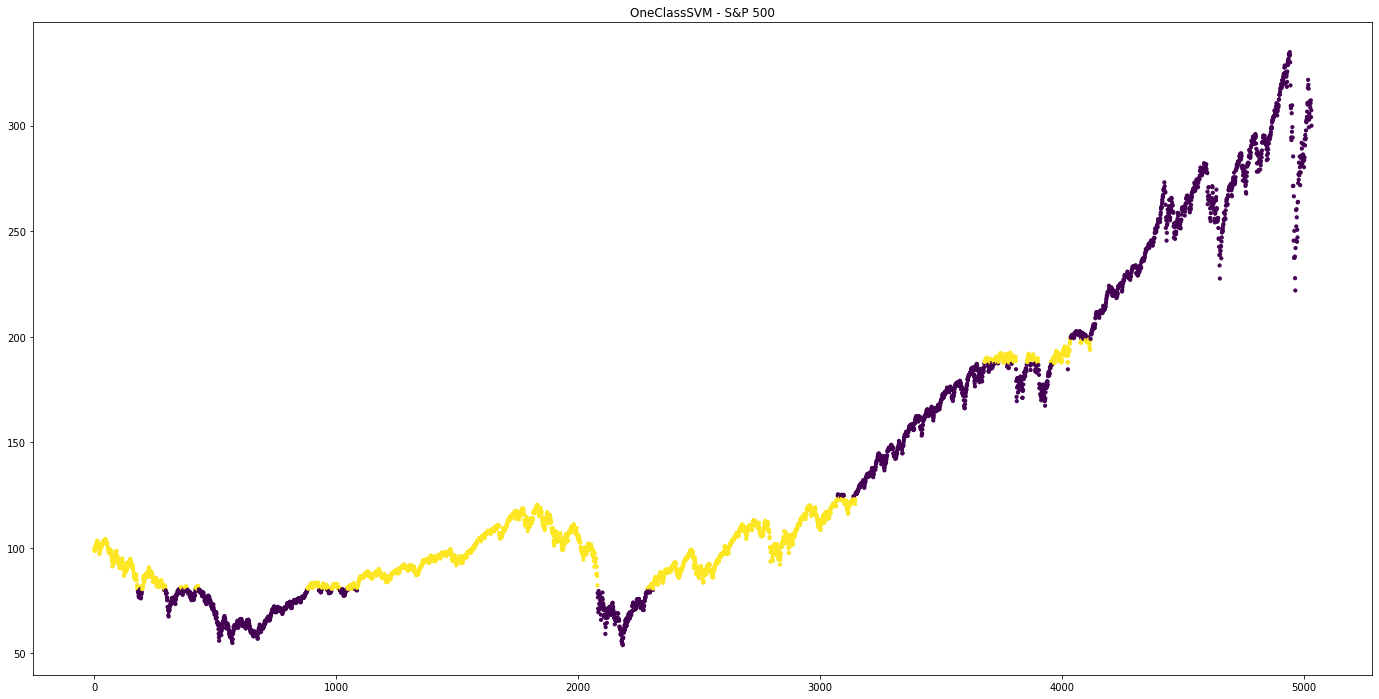

In [21]:
plt.figure(figsize=(24,12))
plt.title("OneClassSVM - S&P 500")
plt.scatter(range(len(x_nested)), x_nested,s=10,c=pred)

<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'OneClassSVM - S&P 500')

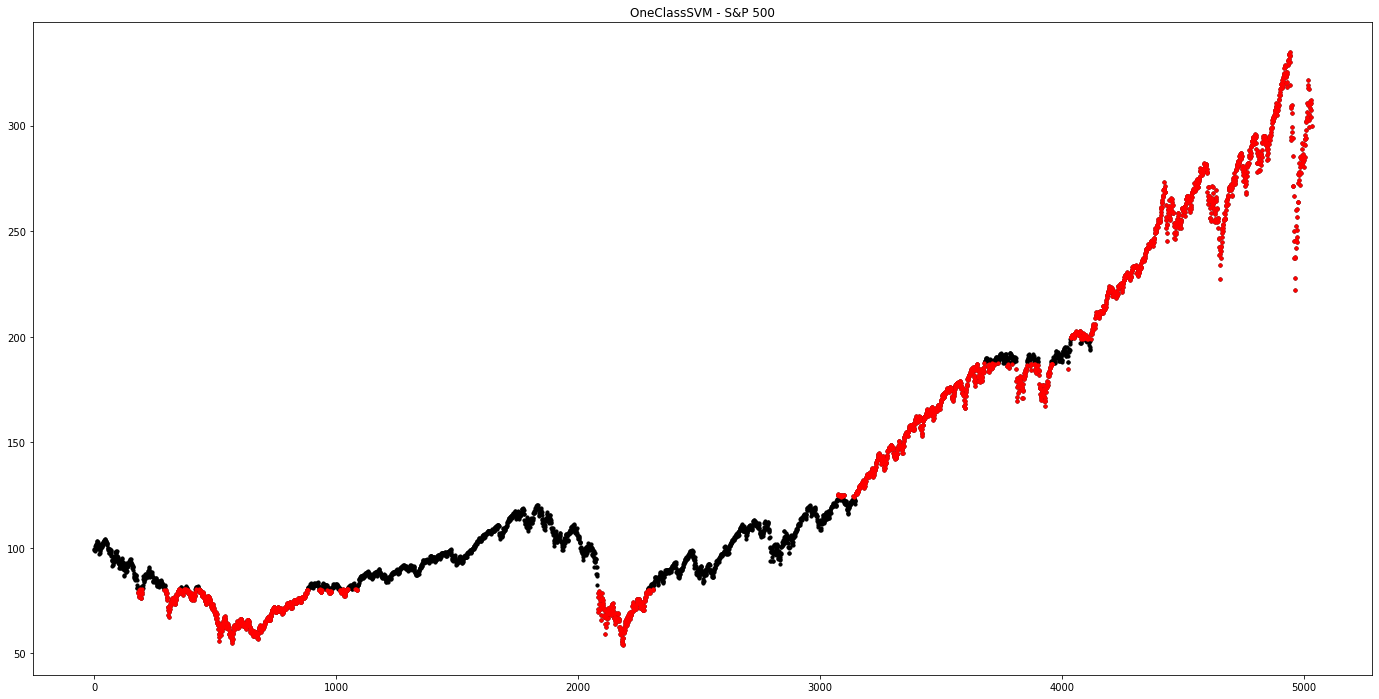

In [22]:
plt.figure(figsize=(24,12))
plt.title("OneClassSVM - S&P 500")
plt.scatter(range(len(x_nested)), x_nested,s=10,c='k')
plt.scatter(itemindex,x[itemindex],s=10,color='r') #

## Let's try LocalOutLierFactor 

In [23]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=40, contamination ='auto') 
pred = lof.fit_predict(x_nested)

arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

len of arry:       5032
len of itemindex:  43


<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'LocalOutlierFactor - S&P 500')

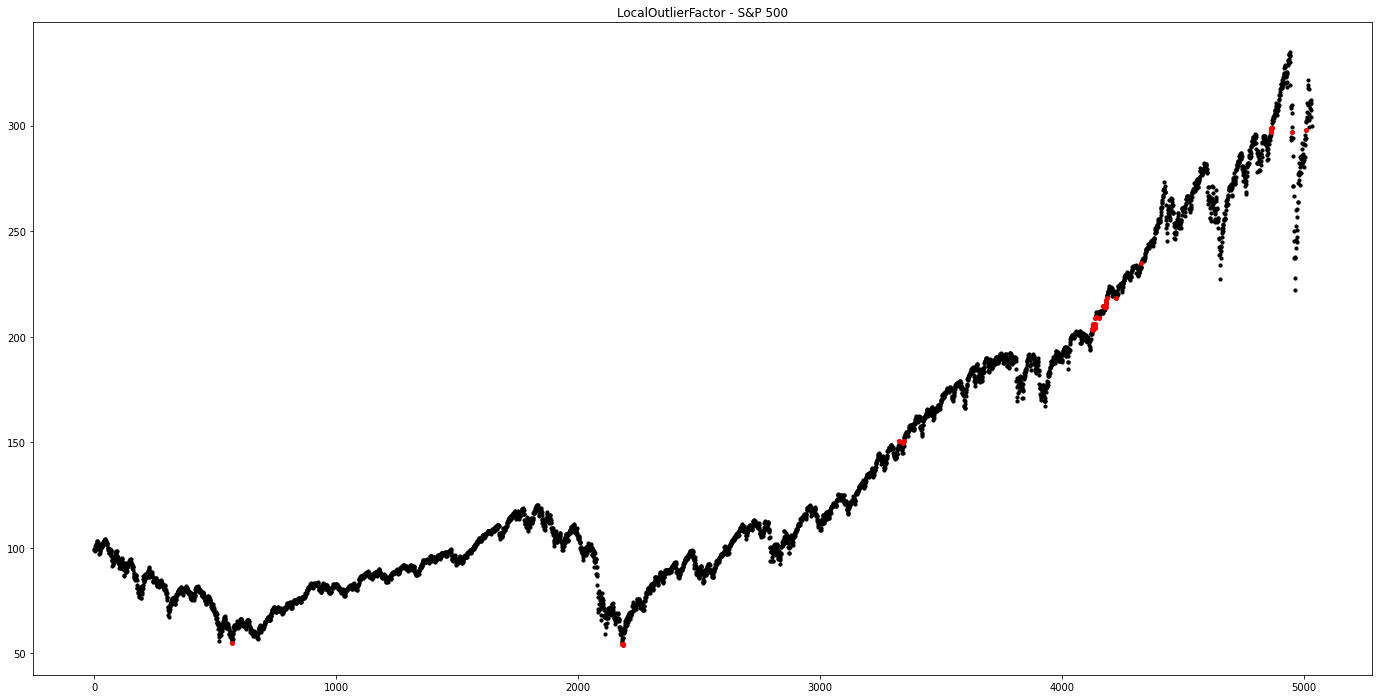

In [24]:
plt.figure(figsize=(24,12))
plt.title("LocalOutlierFactor - S&P 500")
plt.scatter(range(len(x_nested)), x_nested, s=10, c='k')
plt.scatter(itemindex,x[itemindex], s=15, color='r') #

len of arry:       5032
len of itemindex:  252


<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'LocalOutlierFactor - S&P 500')

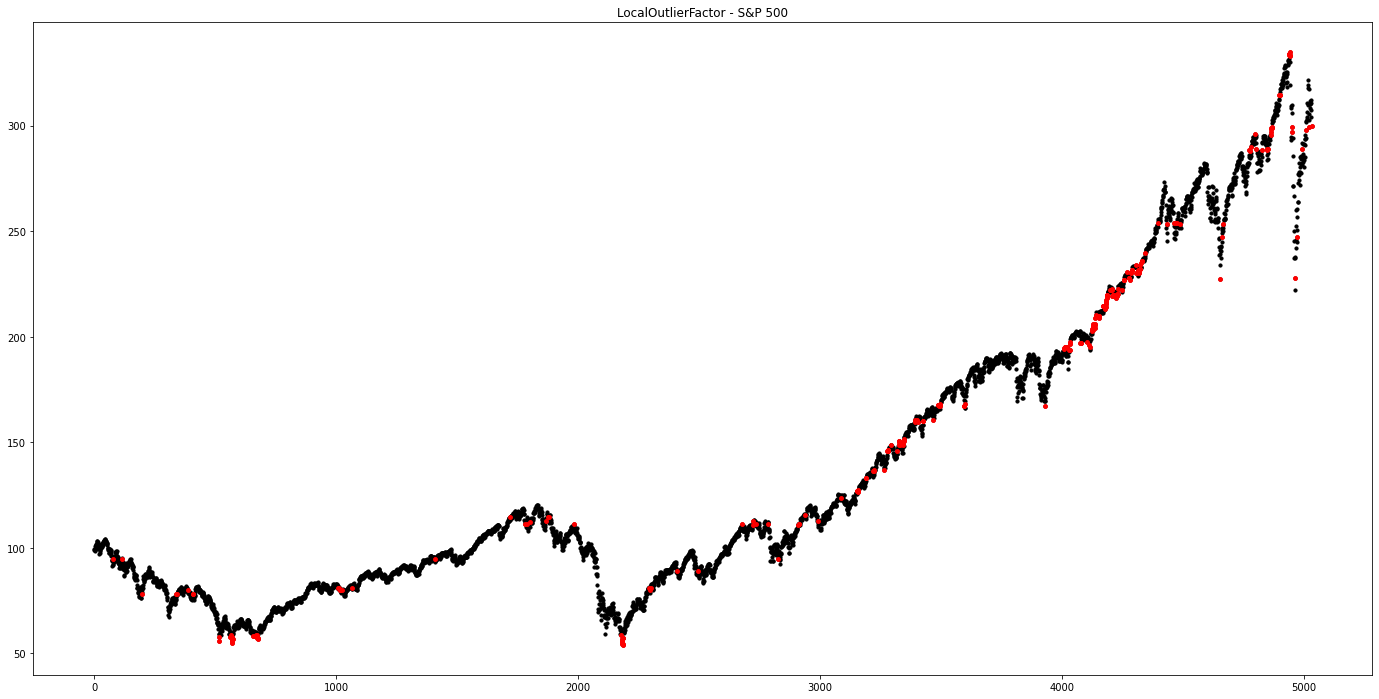

In [25]:
lof = LocalOutlierFactor(n_neighbors=20,algorithm='auto', leaf_size=40, contamination =0.05) # changed contamination
pred = lof.fit_predict(x_nested)

arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)
print('len of arry:      ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

plt.figure(figsize=(24,12))
plt.title("LocalOutlierFactor - S&P 500")
plt.scatter(range(len(x_nested)), x_nested, s=10, c='k')
plt.scatter(itemindex,x[itemindex],s=15,color='r') #

In [26]:
'''
The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.

'''
NOF = lof.negative_outlier_factor_
print(NOF)

'\nThe opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.\n\n'

[-0.98887918 -0.99511624 -0.97191846 ... -0.99167476 -0.96637884
 -1.20632954]


In [27]:
NOF = np.abs( NOF + 1)
NOF_sorted = np.argsort(NOF)
NOF_sorted = NOF_sorted[::-1]
numb_wanted = round(NOF_sorted.shape[0] * 0.05)
contaminated = NOF_sorted[:numb_wanted]
print(contaminated)

[4136 4328 4132 4129 2185 4128 4131 4133 4865 4137 4130 5008 4127 4183
 4867 4864 4181 2183 3326 4138 2184 3327 4154 4950 4135 3346 4863 4225
 4170 4134 4125 4184 4182 4177 4171  572 4139 4180 3344 4172 4179 4178
 4126 4289 4228 3328 4255 4282 4288 4254 4212 2181 4186 4290 4208 4315
 4032  570 4321  117 1407 3347 4211 4227 4652 4324 4185 3319 4153 4123
 4113 2827 1779 3489 4257 4079 4256 3496 4224 4210 2180 4152 3279 4866
 5020 4952 4774 4849 3281 3488 3468 3189 4187  517 4941 3401 4852 4845
 3343 1065 4012 4078 4276 3325 4799 2786 4308 3278 3596 4278 4011 3426
 1983 4143 3282 4963 3930 4076 2736 3155 4803 3427 3156 3154 3153 4775
 4320 3157 3190 2678 4209 2292 2300 1008 4022 4331 4329 4114 3294 4286
 4826 4939 4010 3599 3393 1790 2914 4287 4991 4317 4206 4033 4270 4197
 4937  571 4202  573 4319 1013 4207 4249 4304 4318 4316 2186 4201  568
  561  408 2182 4102 4862  677 4435 2407  658 3497  564  340 4898 4938
  659 1016 3406  569 2910 4463 4009 4488 4942 3223 4323  196  387 2299
 1876 

<Figure size 1728x864 with 0 Axes>

Text(0.5, 1.0, 'LocalOutlierFactor - S&P 500')

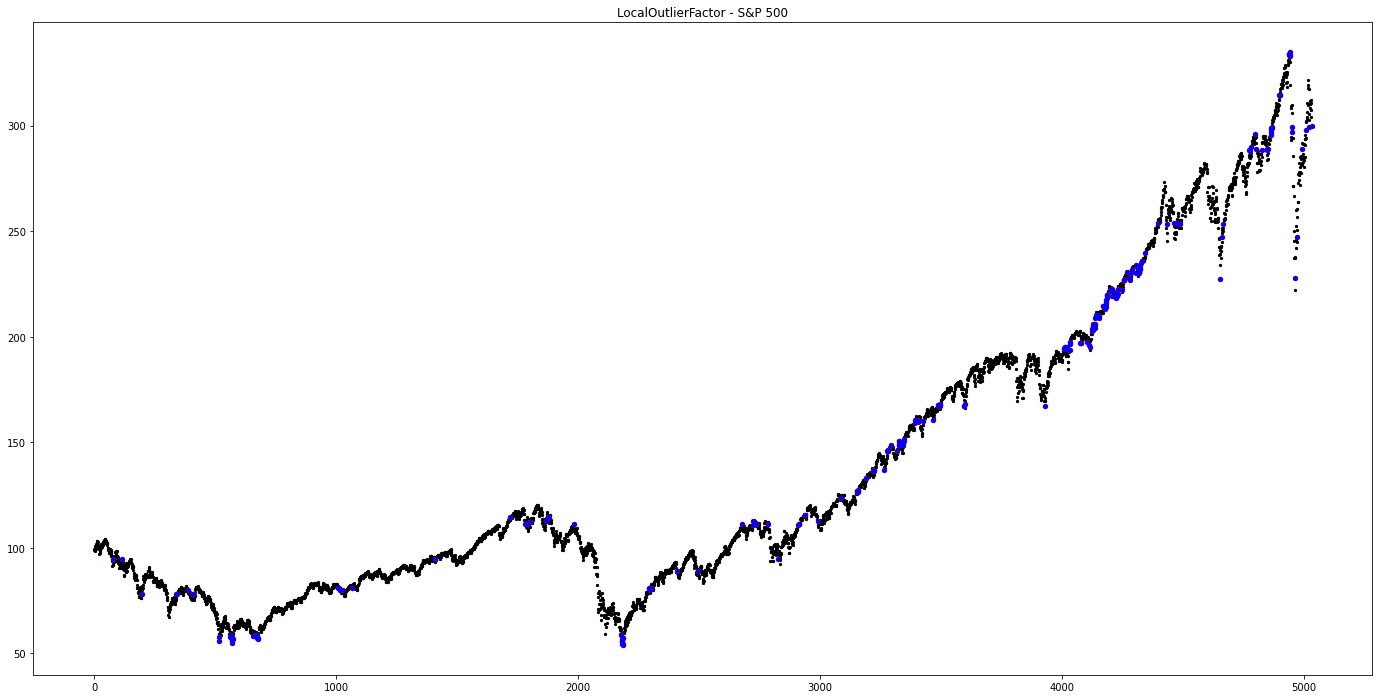

In [28]:
plt.figure(figsize=(24,12))
plt.title("LocalOutlierFactor - S&P 500")
plt.scatter(range(len(x_nested)), x_nested, s=5, c='k', label = "data")
plt.scatter(itemindex,x[itemindex], s=20, color='r', label='AD via predict') #
plt.scatter(contaminated,x_nested[contaminated], s=15, color='b', label = "AD via negative_outlier_factor_") #

# so IsolationForest, and LocalOutlierFactor are the best

## Let's try DBscan

 tune eps to get  < 3% in itemindex (number of anomalies) 

In [29]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=.55,leaf_size=500)

pred = dbscan.fit_predict(x_nested)
pred = pred.reshape(1,-1)[0]
itemindex = np.where(arry==-1)

print('\nlen of pred:      ',len(pred))
print('len of itemindex: ',len(itemindex[0]))
arry


len of pred:       5032
len of itemindex:  252


array([ 1,  1,  1, ...,  1,  1, -1])

**NOISY SAMPLES**

<Figure size 1152x432 with 0 Axes>

Text(0.5, 1.0, 'DBSCAN NOISY SAMPLES - S&P 500')

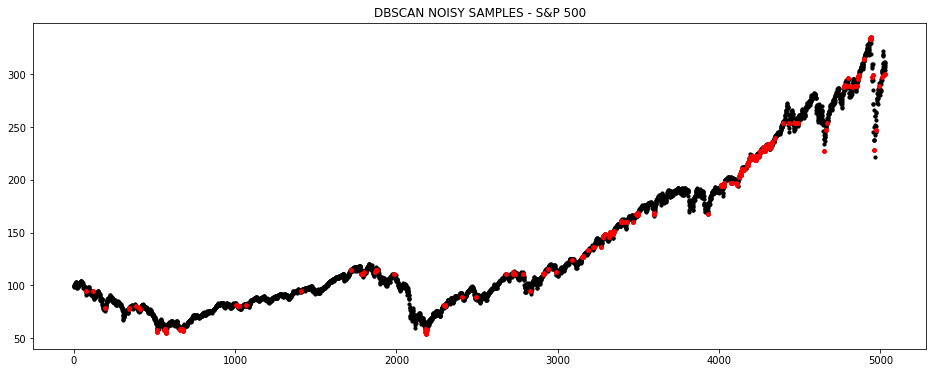

In [30]:
plt.figure(figsize=(16,6))
plt.title("DBSCAN NOISY SAMPLES - S&P 500")
plt.scatter(range(len(x_nested)), x_nested,s=10,c='k')
plt.scatter(itemindex,x[itemindex], s=15, color='r') #

Text(0.5, 1.0, 'DBSCAN - S&P 500')

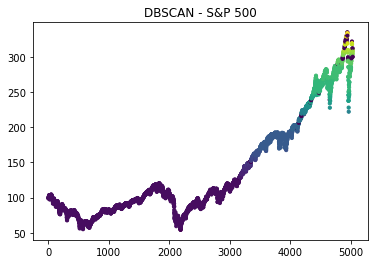

In [31]:
#plt.figure(figsize=(24,12))
plt.title("DBSCAN - S&P 500")
plt.scatter(range(len(x_nested)), x_nested, s=10, c=dbscan.labels_)

In [32]:
x_nested
from collections import Counter
# print(Counter(dbscan.labels_))

array([[ 99.25],
       [ 99.53],
       [ 98.59],
       ...,
       [304.09],
       [307.35],
       [300.05]])

In [33]:
print(len(set(dbscan.labels_)), "clusters....")

33 clusters....


# let's try using pyod

[Implemented Algorithms](https://github.com/yzhao062/pyod#implemented-algorithms)

In [34]:
import gc 
gc.collect()
!pip install pyod

41


len of arry:     5032
len of itemindex:  252


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


<Figure size 1152x288 with 0 Axes>

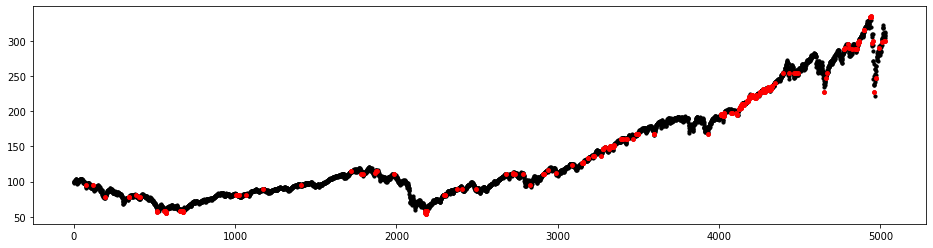

In [38]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
# from pyod.models.auto_encoder import AutoEncoder
from pyod.models.abod import ABOD

lof= LOF(contamination=0.05)
pred=lof.fit_predict(x_nested)
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==1)

print('\nlen of arry:    ',len(arry))
print('len of itemindex: ',len(itemindex[0]))

plt.figure(figsize=(16,4))
plt.scatter(range(len(x_nested)), x_nested,s=10,c='k')
plt.scatter(itemindex,x[itemindex], s=15, color='r')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


<Figure size 1152x288 with 0 Axes>

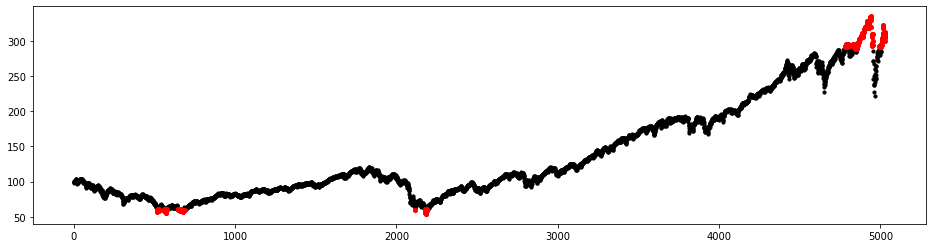

In [39]:
iforest= IForest(contamination=0.05)
pred=iforest.fit_predict(x_nested)
arry = pred.reshape(1,-1)[0]
itemindex = np.where(arry==1)

plt.figure(figsize=(16,4))
plt.scatter(range(len(x_nested)), x_nested,s=10,c='k')
plt.scatter(itemindex,x[itemindex], s=15, color='r')